<a href="https://colab.research.google.com/github/nmk1406/customer-segmentation/blob/main/customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer Segmentation**


**Author:** Nguyen Minh Khoa

**Email:** nmk14062001@gmail.com

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

Load data

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/nmk1406/customer-segmentation/main/data/dataCustomerRFM.csv')

## **P1: Exploratory data analysis**

In [3]:
df.head()

,CustomerID,OrderDate,OrderID,Amount
0,b5731a6437,2019-07-09 23:56:44,f996cde8437b432580ae2d9c61b1470c,6249000.0
1,ba9a96efd7,2019-07-27 22:25:52,f9e7114611c34377b456774a05310bb5,816200.0
2,3bb7d08ac6,2019-09-30 06:29:39,f9f793f21dc24607a7ca4dae6c3abed3,77000.0
3,9cf0875c93,2019-07-31 16:12:51,83ccdf7eb8944a23b0ef706551c1a818,997000.0
4,b50d95bb37,2019-08-29 06:11:15,7fc8a7e9f6da4d76b9e562ce2ca58e97,380700.0


In [4]:
df.shape

(303295, 4)

Check missing value

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303295 entries, 0 to 303294
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   CustomerID  303295 non-null  object 
 1   OrderDate   303295 non-null  object 
 2   OrderID     303295 non-null  object 
 3   Amount      303292 non-null  float64
dtypes: float64(1), object(3)
memory usage: 9.3+ MB


Check duplicated data

In [6]:
df.duplicated().sum()

0

## **P2: RFM model**

Convert datatype of OrderDate to datetime

In [7]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'], format = '%Y-%m-%d %H:%M:%S')

In [8]:
current_date = max(df['OrderDate']) + datetime.timedelta(days = 1)

Caculate Rencency - Frequency - Monetary

In [9]:
df = df.groupby(['CustomerID']).agg(
    {'OrderDate': lambda x: (current_date - x.max()).days,
     'OrderID': lambda x: x.nunique(),
     'Amount': 'sum'}
)

Rename columns

In [10]:
df = df.rename(columns = {'OrderDate': 'Recency',
                          'OrderID': 'Frequency',
                          'Amount': 'Monetary'})

In [11]:
df.head()

,Recency,Frequency,Monetary
CustomerID,,,
0.00E+00,11,29,111358900.0
00002e4215,41,1,1270000.0
0000cb9c0c,13,5,39548000.0
00014d86cf,30,3,1013000.0
00014e8418,54,1,1299000.0


Filter data with Monetary > 0

In [12]:
df = df[df['Monetary'] > 0]

## **P3: Data pre-processing**

Handle skewed data

In [13]:
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(4, 1, figsize = (10, 10))
    sns.distplot(df[x], ax = ax[0])
    sns.distplot(np.log(df[x]), ax = ax[1])
    sns.distplot(np.sqrt(df[x]), ax = ax[2])
    sns.distplot(stats.boxcox(df[x])[0], ax = ax[3])
    plt.tight_layout()
    plt.show()
    
    print(df[x].skew())
    print(np.log(df[x]).skew())
    print(np.sqrt(df[x]).skew())
    print(pd.Series(stats.boxcox(df[x])[0]).skew())

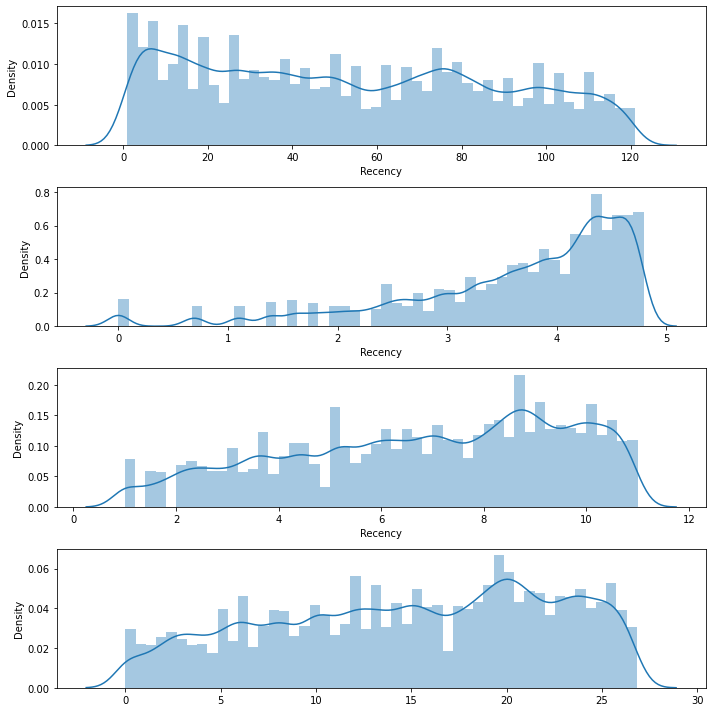

0.1781333641386202
-1.3312331476815877
-0.36680526701305
-0.2514786268332924


In [14]:
analyze_skewness('Recency')

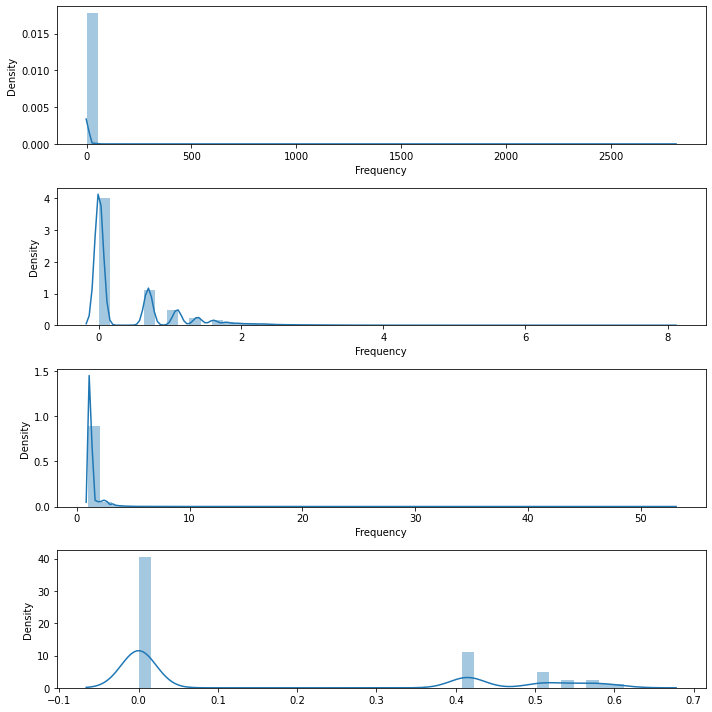

226.6470433056158
1.7770935049663812
9.536411193231588
0.6687487990616232


In [15]:
analyze_skewness('Frequency')

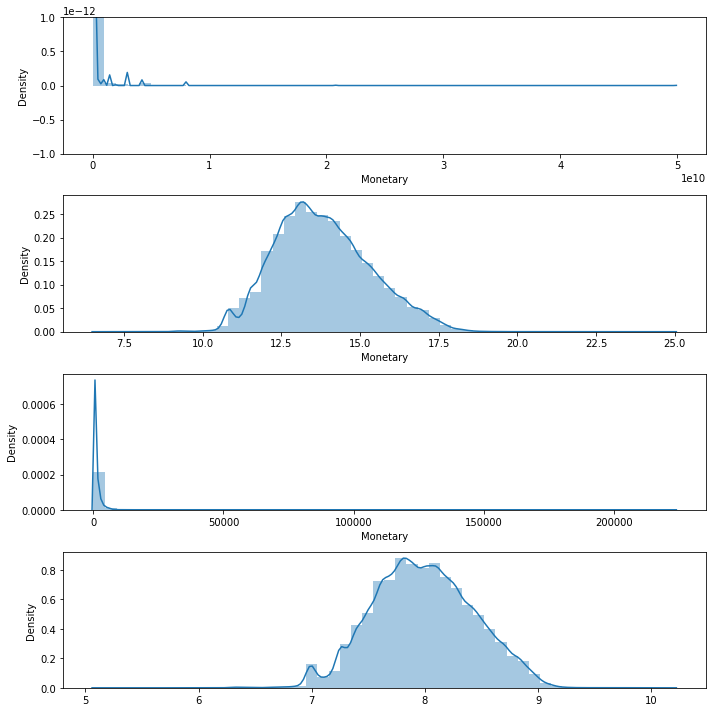

254.9051417117874
0.3691155177328851
33.519830992966035
0.008221213453139127


In [16]:
analyze_skewness('Monetary')

Use cox box to transform Frequency and Monetary

In [17]:
new_df = pd.DataFrame()
new_df['Recency'] = df['Recency']
new_df['Frequency'] = stats.boxcox(df['Frequency'])[0]
new_df['Monetary'] = stats.boxcox(df['Monetary'])[0]

Visualize Rencency - Frequency - Monetary after tranform

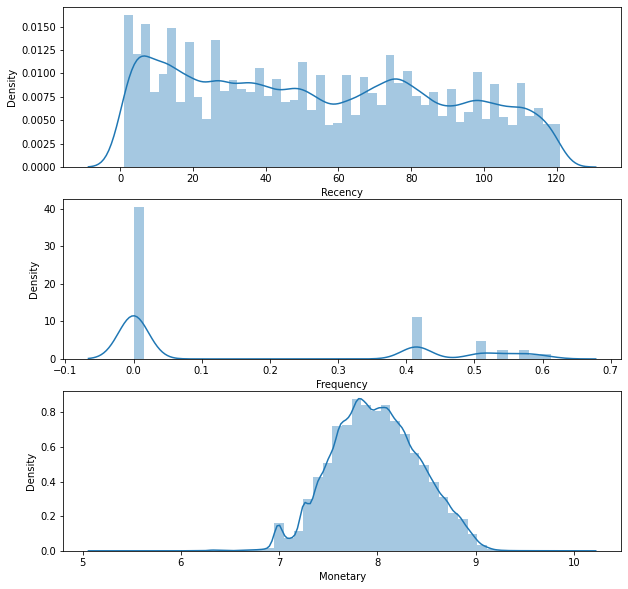

In [18]:
fig, ax = plt.subplots(3, 1, figsize = (10, 10))
sns.distplot(new_df['Recency'], ax = ax[0])
sns.distplot(new_df['Frequency'], ax = ax[1])
sns.distplot(new_df['Monetary'], ax = ax[2])
plt.show()

Use standard scale to scale data

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(new_df)
data_normalized = scaler.transform(new_df)

In [20]:
new_df = pd.DataFrame(data_normalized)

In [21]:
new_df.head()

,0,1,2
0,-1.234353,1.833728,2.657525
1,-0.371447,-0.743786,0.220788
2,-1.176826,1.657884,2.175399
3,-0.687846,1.414686,0.070455
4,0.002479,-0.743786,0.235637


## **P4: Choose k for K-means**

Use elbow method to choose k

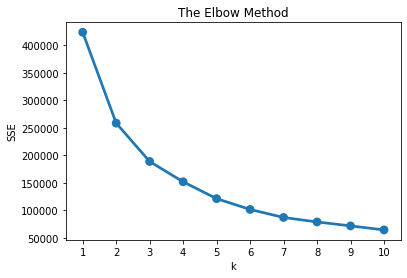

In [22]:
from sklearn.cluster import KMeans

sse = {}
for k in range(1, 11):
    km = KMeans(n_clusters = k, random_state = 1)
    km.fit(new_df)
    sse[k] = km.inertia_ 
    
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x = list(sse.keys()), y = list(sse.values()))
plt.show()

Best result corresponding to k = 3

Use silhouette method to check with k = 3

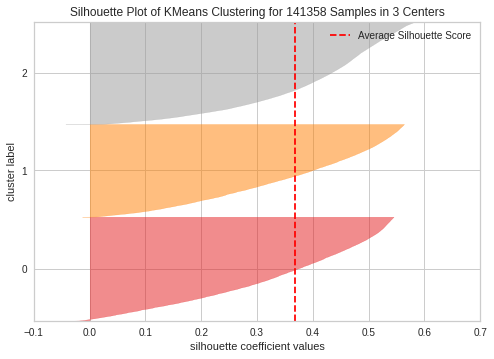

In [23]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

km = KMeans(n_clusters = 3, random_state = 1)

visualizer = SilhouetteVisualizer(km)
visualizer.fit(new_df)    
visualizer.show()

- With k = 3, all clusters have similar size.

Choose k = 3 to train model

## **P5: Train model**

In [24]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=42)
km.fit(new_df)

KMeans(n_clusters=3, random_state=42)

Assign clusters to data

In [25]:
df['Cluster'] = km.labels_
df.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
0.00E+00,11,29,111358900.0,1
00002e4215,41,1,1270000.0,2
0000cb9c0c,13,5,39548000.0,1
00014d86cf,30,3,1013000.0,1
00014e8418,54,1,1299000.0,2


In [26]:
df.groupby('Cluster').agg(
    {'Recency': 'mean',
     'Frequency': 'mean',
     'Monetary': 'mean'}
)

,Recency,Frequency,Monetary
Cluster,,,
0,90.329488,1.061975,1.975908e+06
1,39.054680,4.171901,8.996822e+06
2,29.489572,1.004490,2.476813e+06


## **P6: Conclusion**

- **Cluster 1:** Customers of this group have not purchased for a long time. We need to check why they don't buy anymore and methods to reach them.
- **Cluster 2:** Customers of this group buy a lot, and they spend quite a lot of money on shopping. This is a group that needs special care.
- **Cluster 3:** This may be a new group of customers because they buy quite a bit.

